# Pytorch Audio Emotion Classifier - Neel Patel

# 1. Data Preprocessing

## Go to !End of DataPreprocessing to run the cells before this

In [2]:
# Import packages!

import os
import shutil
from zipfile import ZipFile
import time
import random
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
import librosa

from IPython.display import Audio

import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torchaudio
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
import torchaudio.transforms as T
from sklearn.model_selection import train_test_split

import torch.multiprocessing as mp

mp.set_start_method("spawn", force=True)

#Use GPU acceleration if possible
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
   
print(f'Using {device}') 

# Set seeds for reproducibility

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)  # If using CUDA

AUGMENTATIONS_LOADED = False

Using cpu


## 2. Transfer Learning

In [3]:
train_data = pd.read_csv("/kaggle/input/metadata-and-augmentations/augmented_training_df.csv")
test_data = pd.read_csv("/kaggle/input/metadata-and-augmentations/testing_df.csv")

In [4]:
train_data['Filepath']='/kaggle/input/metadata-and-augmentations/'+train_data['Filepath']

In [16]:
# pip install tensorflow

In [20]:
# pip install tensorflow_io

In [5]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [6]:
yamnet_model = hub.load('https://www.kaggle.com/models/google/yamnet/TensorFlow2/yamnet/1')

In [7]:
@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [8]:
def load_wav_for_map(filename, label):
    return load_wav_16k_mono(filename), label

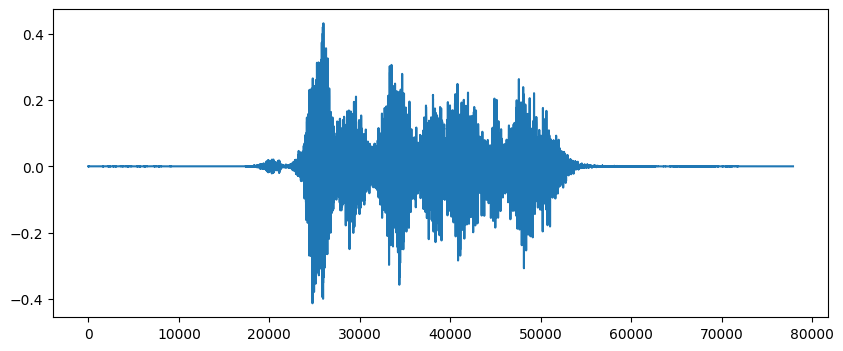

In [9]:
file_contents = tf.io.read_file(testing_wav_file_name)

# Decode the WAV file
audio, sample_rate = tf.audio.decode_wav(file_contents)

# Extract the audio signal (TensorFlow stores it as a tensor)
audio_signal = tf.squeeze(audio)  # Remove unnecessary dimensions if present

# Plot the waveform
plt.figure(figsize=(10, 4))
plt.plot(audio_signal)

In [9]:
labels = train_data['Gender'].unique().tolist()

In [10]:
keys = set(train_data.Gender)
values = np.arange(0, len(keys))
code_dict = dict(zip(sorted(keys), values))
train_data['label'] = train_data['Gender'].apply(lambda x: code_dict[x])
train_data.head()

,Filename,Filepath,Gender,Emotion,Emotional Intensity,Augmentation_Type,label
0,03-01-01-01-01-01-02_augmented_training_V1_1.wav,/kaggle/input/metadata-and-augmentations/augme...,female,neutral,medium,AugmentedV,0
1,03-01-07-02-01-02-02_augmented_training_V1_2.wav,/kaggle/input/metadata-and-augmentations/augme...,female,disgust,high,AugmentedV,0
2,03-01-07-01-01-02-02_augmented_training_V1_3.wav,/kaggle/input/metadata-and-augmentations/augme...,female,disgust,medium,AugmentedV,0
3,03-01-01-01-02-01-02_augmented_training_V1_4.wav,/kaggle/input/metadata-and-augmentations/augme...,female,neutral,medium,AugmentedV,0
4,03-01-06-02-02-01-02_augmented_training_V1_5.wav,/kaggle/input/metadata-and-augmentations/augme...,female,fear,high,AugmentedV,0


In [11]:
classes_df = pd.DataFrame()
classes_df = train_data.filter(['Gender','label'],axis=1)
classes_df = classes_df.drop_duplicates()
classes_df.reset_index(drop=True, inplace=True)
classes_df

,Gender,label
0,female,0
1,male,1


In [61]:
filenames = train_data['Filepath']
targets = train_data['label']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [62]:
main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [63]:
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings))

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [64]:
cached_ds = main_ds.cache()

In [73]:
dataset_size = len(train_data)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_ds = cached_ds.take(train_size)
test_ds = cached_ds.skip(train_size)

train_ds = train_ds.cache().shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(32).prefetch(tf.data.AUTOTUNE)

In [74]:
for x, y in train_ds.take(1):
    print("Input shape: ", x.shape)  # Should be (batch_size, 1024)
    print("Label shape: ", y.shape) # Should match output nodes

Input shape:  (32, 1024)
Label shape:  (32,)


In [75]:
for x, y in test_ds.take(1):
    print("Input shape: ", x.shape)  # Should be (batch_size, 1024)
    print("Label shape: ", y.shape) # Should match output nodes

KeyboardInterrupt: 

In [66]:
my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(labels))
], name='my_model')

my_model.summary()

Model: "my_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,826 (2.01 MB)

 Trainable params: 525,826 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [69]:
STEPS_PER_EPOCH = train_data.shape[0] // 32

In [70]:
history = my_model.fit(train_ds,
                       steps_per_epoch = STEPS_PER_EPOCH,
                       # validation_data=val_ds,
                       epochs=10)

Epoch 1/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 46s 110ms/step - accuracy: 0.7228 - loss: 0.5803
Epoch 2/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7683 - loss: 0.4858
Epoch 3/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7976 - loss: 0.4437
Epoch 4/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8095 - loss: 0.4183
Epoch 5/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8260 - loss: 0.3874
Epoch 6/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8390 - loss: 0.3790
Epoch 7/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8543 - loss: 0.3342
Epoch 8/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8689 - loss: 0.3045
Epoch 9/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8776 - loss: 0.2946
Epoch 10/10
359/359 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8925 - loss: 0.2680


In [76]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

   1714/Unknown 288s 142ms/step - accuracy: 0.6576 - loss: 0.7078

InvalidArgumentError: Graph execution error:

Detected at node DecodeWav defined at (most recent call last):
<stack traces unavailable>
Bad format chunk size for WAV: Expected 16 or 18, but got40
	 [[{{node DecodeWav}}]]
	 [[IteratorGetNext]] [Op:__inference_one_step_on_iterator_61474]